# 10장 분류

> 다양한 분류 알고리즘의 사용법을 익힙니다.
- author: "Chansung Park"
- toc: true
- comments: true
- permalink: /chapter10/
- badges: true
- sticky_rank: 10

In [ ]:
#hide

!pip install tpot==0.9.5
!pip install yellowbrick==0.9
!pip install dtreeviz==0.8.2
!pip install xgbfir
!pip install scikit-learn==0.21.0
!pip install pandas==0.23.4

     |████████████████████████████████| 901kB 5.3MB/s 
     |████████████████████████████████| 163kB 9.0MB/s 
  Created wheel for tpot: filename=TPOT-0.9.5-cp37-none-any.whl size=70870 sha256=3914296093b5bbfb5ef29fc99204f1f839b7469943743b7b04c0f8b1d315febb
  Stored in directory: /root/.cache/pip/wheels/97/86/27/698a1366f854d2344fd0f7ee9ef57c8044ec02f182c8a0431e
  Created wheel for stopit: filename=stopit-1.1.2-cp37-none-any.whl size=11954 sha256=9e4e2075338b1085f6cc56cad02e3c90eb2fd092417b48be670139e3410dd468
  Stored in directory: /root/.cache/pip/wheels/3c/85/2b/2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
Successfully built tpot stopit
     |████████████████████████████████| 286kB 5.7MB/s 
     |████████████████████████████████| 12.8MB 6.3MB/s 
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: album

  Created wheel for dtreeviz: filename=dtreeviz-0.8.2-cp37-none-any.whl size=24505 sha256=2c1d791568501fec26de2251de6fde2dc08825199991938885865a7fd16c5852
  Stored in directory: /root/.cache/pip/wheels/a2/da/b1/3178bb2b10647b5a6340c1979987e3b0c3b993cb674b0a3dcc
Successfully built dtreeviz
     |████████████████████████████████| 153kB 5.1MB/s 
     |████████████████████████████████| 6.7MB 4.5MB/s 
ERROR: umap-learn 0.5.1 has requirement scikit-learn>=0.22, but you'll have scikit-learn 0.21.0 which is incompatible.
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 8.8MB 5.4MB/s 
ERROR: xarray 0.15.1 has requirement pandas>=0.25, but you'll have pandas 0.23.4 which is incompatible.
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: plotnine 0.6.0 has requirement pandas>=0.25.

In [ ]:
#hide

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#hide

import matplotlib.pyplot as plt
import pandas as pd
from sklearn import (
  ensemble,
  preprocessing,
  tree
)
from sklearn.metrics import (
  auc,
  confusion_matrix,
  roc_auc_score,
  roc_curve
)
from sklearn.model_selection import (
  train_test_split,
  StratifiedKFold
)
from yellowbrick.classifier import (
  ConfusionMatrix,
  ROCAUC
)
from yellowbrick.model_selection import (
  LearningCurve
)

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:
#hide

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.experimental import (
    enable_iterative_imputer,
)
from sklearn import (
    ensemble,
    impute,
    model_selection,    
    preprocessing,
    tree,
)

url = "https://biostat.app.vumc.org/wiki/pub/Main/DataSets/titanic3.xls"

df = pd.read_excel(url)
def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None
):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=size, random_state=42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()

    fitted = fi.fit_transform(X_train[num_cols])
    X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    if std_cols:
        std = preprocessing.StandardScaler()
        fitted = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test

ti_df = tweak_titanic(df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])


# 10.1 로지스틱 회귀

In [ ]:
from sklearn.linear_model import (
  LogisticRegression,
)

lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
lr.score(X_test, y_test)

0.8015267175572519

In [ ]:
lr.predict(X.iloc[[0]])

array([0])

In [ ]:
lr.predict_proba(X.iloc[[0]])

array([[0.89709139, 0.10290861]])

In [ ]:
lr.predict_log_proba(X.iloc[[0]])

array([[-0.10859754, -2.27391397]])

In [ ]:
lr.decision_function(X.iloc[[0]])

array([-2.16531643])

In [ ]:
lr.intercept_

array([1.22466932])

In [ ]:
import numpy as np

def inv_logit(p):
  return np.exp(p) / (1 + np.exp(p))

inv_logit(lr.intercept_)

array([0.77288422])

In [ ]:
cols = X.columns
for col, val in sorted(zip(cols, lr.coef_[0]),
                       key=lambda x: x[1],
                       reverse=True):
  print(f"{col:10}{val:10.3f} {inv_logit(val):10.3f}")

fare           0.104      0.526
parch         -0.063      0.484
sibsp         -0.273      0.432
age           -0.295      0.427
embarked_Q    -0.495      0.379
embarked_S    -0.508      0.376
pclass        -0.738      0.323
sex_male      -2.408      0.083


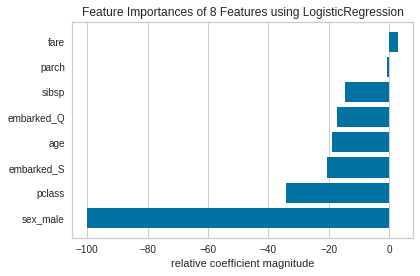

In [ ]:
from yellowbrick.features.importances import (
  FeatureImportances,
)

fig, ax = plt.subplots(figsize=(6, 4))
fi_viz = FeatureImportances(lr)
fi_viz.fit(X, y)
fi_viz.poof()

# 10.2 나이브 베이즈

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
nb.score(X_test, y_test)

0.7557251908396947

In [ ]:
nb.predict(X.iloc[[0]])

array([0])

In [ ]:
nb.predict_proba(X.iloc[[0]])

array([[0.95955327, 0.04044673]])

In [ ]:
nb.predict_log_proba(X.iloc[[0]])

array([[-0.04128744, -3.20776959]])

# 10.3 서포트 벡터 머신

In [ ]:
from sklearn.svm import SVC
svc = SVC(random_state=42, probability=True)
svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=42,
    shrinking=True, tol=0.001, verbose=False)

In [ ]:
svc.score(X_test, y_test)

0.806615776081425

In [ ]:
svc.predict(X.iloc[[0]])

array([0])

In [ ]:
svc.predict_proba(X.iloc[[0]])

array([[0.84850738, 0.15149262]])

In [ ]:
svc.predict_log_proba(X.iloc[[0]])

array([[-0.1642765 , -1.88721835]])

# 10.4 K-최근접 이웃

In [ ]:
from sklearn.neighbors import (
  KNeighborsClassifier,
)

knc = KNeighborsClassifier()
knc.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
knc.score(X_test, y_test)

0.7684478371501272

In [ ]:
knc.predict(X.iloc[[0]])

array([0])

In [ ]:
knc.predict_proba(X.iloc[[0]])

array([[0.8, 0.2]])

# 10.5 디시전 트리

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(
  random_state=42, max_depth=3
)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [ ]:
dt.score(X_test, y_test)

0.8142493638676844

In [ ]:
dt.predict(X.iloc[[0]])

array([0])

In [ ]:
dt.predict_proba(X.iloc[[0]])

array([[0.87954545, 0.12045455]])

In [ ]:
dt.predict_log_proba(X.iloc[[0]])

array([[-0.12835003, -2.11648281]])

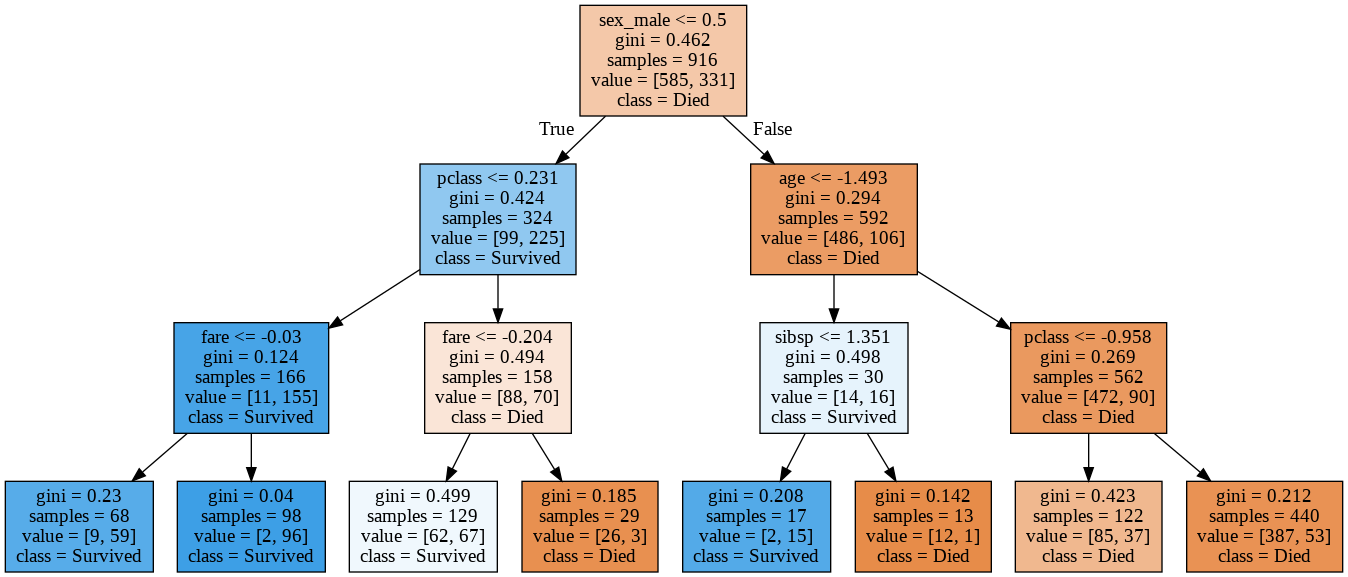

In [ ]:
import pydotplus
from io import StringIO
from sklearn.tree import export_graphviz
from IPython.display import Image

dot_data = StringIO()

tree.export_graphviz(
  dt,
  out_file=dot_data,
  feature_names=X.columns,
  class_names=["Died", "Survived"],
  filled=True,
)

g = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(g.create_png())

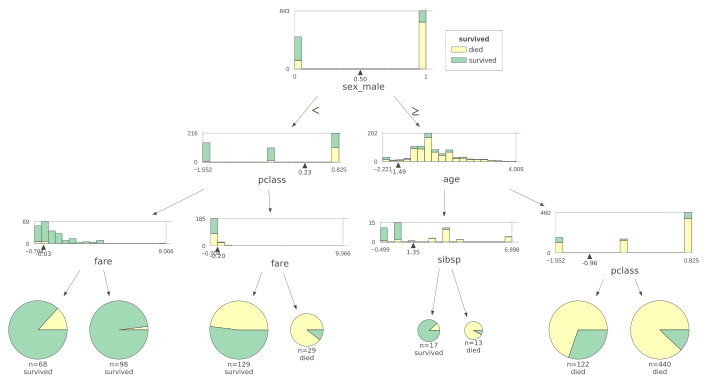

In [ ]:
from dtreeviz.trees import dtreeviz

viz = dtreeviz(
  dt,
  X,
  y,
  target_name="survived",
  feature_names=X.columns,
  class_names=["died", "survived"],
)

viz

In [ ]:
for col, val in sorted(zip(X.columns, dt.feature_importances_),
                       key=lambda x: x[1],
                       reverse=True)[:5]:
  print(f"{col:10}{val:10.3f}")

sex_male       0.607
pclass         0.248
sibsp          0.052
fare           0.050
age            0.043


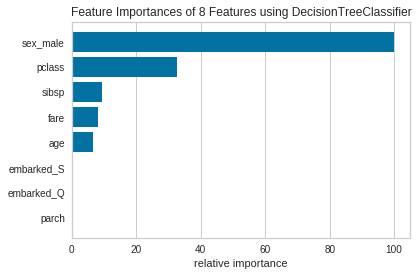

In [ ]:
from yellowbrick.features.importances import (
  FeatureImportances,
)

fig, ax = plt.subplots(figsize=(6, 4))
fi_viz = FeatureImportances(dt)
fi_viz.fit(X, y)
fi_viz.poof()

# 10.6 랜덤포레스트

In [ ]:
from sklearn.ensemble import (
  RandomForestClassifier,
)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
rf.score(X_test, y_test)

0.7659033078880407

In [ ]:
rf.predict(X.iloc[[0]])

array([0])

In [ ]:
rf.predict_proba(X.iloc[[0]])

array([[1., 0.]])

In [ ]:
rf.predict_log_proba(X.iloc[[0]])

array([[  0., -inf]])

In [ ]:
for col, val in sorted(zip(X.columns, rf.feature_importances_),
                       key=lambda x: x[1],
                       reverse=True)[:5]:
  print(f"{col:10}{val:10.3f}")

age            0.280
fare           0.274
sex_male       0.230
pclass         0.086
sibsp          0.053


# 10.7 XGBoost

In [ ]:
import xgboost as xgb
xgb_class = xgb.XGBClassifier(random_state=42)
xgb_class.fit(
  X_train,
  y_train,
  early_stopping_rounds=10,
  eval_set=[(X_test, y_test)],
)

[0]	validation_0-error:0.188295
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.188295
[2]	validation_0-error:0.188295
[3]	validation_0-error:0.188295
[4]	validation_0-error:0.188295
[5]	validation_0-error:0.188295
[6]	validation_0-error:0.203562
[7]	validation_0-error:0.203562
[8]	validation_0-error:0.203562
[9]	validation_0-error:0.203562
[10]	validation_0-error:0.203562
Stopping. Best iteration:
[0]	validation_0-error:0.188295



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
xgb_class.score(X_test, y_test)

0.811704834605598

In [ ]:
xgb_class.predict(X.iloc[[0]])

array([0])

In [ ]:
xgb_class.predict_proba(X.iloc[[0]])

array([[0.53754187, 0.46245816]], dtype=float32)

In [ ]:
for col, val in sorted(zip(X.columns, xgb_class.feature_importances_,),
                       key=lambda x: x[1],
                       reverse=True)[:5]:
  print(f"{col:10}{val:10.3f}")

sex_male       0.665
pclass         0.155
sibsp          0.069
embarked_S     0.042
age            0.038


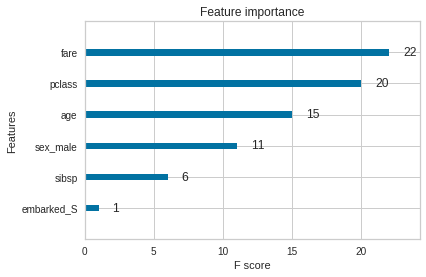

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
xgb.plot_importance(xgb_class, ax=ax)

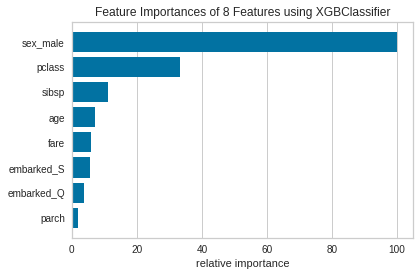

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
fi_viz = FeatureImportances(xgb_class)
fi_viz.fit(X, y)
fi_viz.poof()

In [ ]:
booster = xgb_class.get_booster()
print(booster.get_dump()[0])

0:[sex_male<1] yes=1,no=2,missing=1
	1:[pclass<0.23096557] yes=3,no=4,missing=3
		3:[fare<-0.142878294] yes=7,no=8,missing=7
			7:leaf=0.132530123
			8:leaf=0.184
		4:[fare<-0.195437849] yes=9,no=10,missing=9
			9:leaf=0.0245989319
			10:leaf=-0.145945951
	2:[age<-1.49289274] yes=5,no=6,missing=5
		5:[sibsp<1.81278062] yes=11,no=12,missing=11
			11:leaf=0.135483876
			12:leaf=-0.150000006
		6:[pclass<-0.957598865] yes=13,no=14,missing=13
			13:leaf=-0.0666666701
			14:leaf=-0.148717955



In [ ]:
1 / (1 + np.exp(-1 * 0.1238))

0.5309105310475829

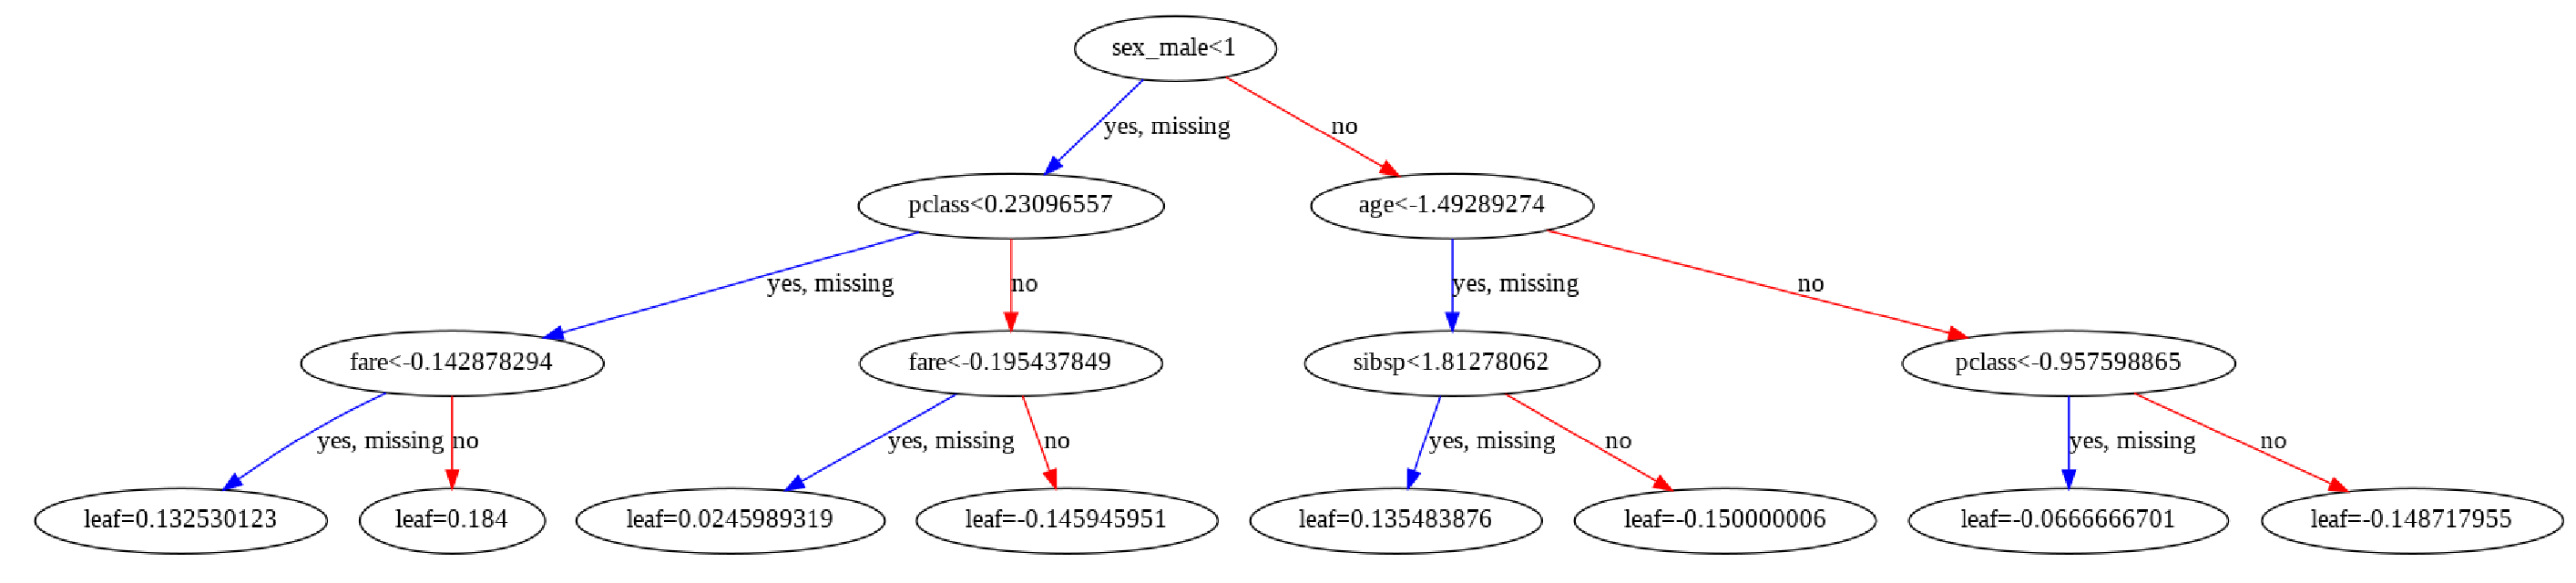

In [ ]:
fig, ax = plt.subplots(figsize=(50, 50))
xgb.plot_tree(xgb_class, ax=ax, num_trees=0)

In [ ]:
import xgbfir

xgbfir.saveXgbFI(
  xgb_class,
  feature_names=X.columns,
  OutputXlsxFile="fir.xlsx",
)
pd.read_excel("/content/fir.xlsx").head(3).T

,0,1,2
Interaction,sex_male,pclass,fare
Gain,2026.35,743.409,711.231
FScore,48,53,279
wFScore,39.4676,22.203,121.88
Average wFScore,0.822241,0.418924,0.436845
Average Gain,42.2157,14.0266,2.54922
Expected Gain,2016.01,298.442,291.862
Gain Rank,1,2,3
FScore Rank,4,3,1
wFScore Rank,3,4,1


In [ ]:
pd.read_excel(
  "fir.xlsx",
  sheet_name="Interaction Depth 1",
).head(2).T

,0,1
Interaction,pclass|sex_male,age|sex_male
Gain,3301.86,1378.75
FScore,38,15
wFScore,15.9816,8.5093
Average wFScore,0.420569,0.567287
Average Gain,86.8911,91.9168
Expected Gain,1375.25,885.229
Gain Rank,1,2
FScore Rank,4,12
wFScore Rank,4,9


In [ ]:
pd.read_excel(
  "fir.xlsx",
  sheet_name="Interaction Depth 2",
).head(1).T

,0
Interaction,fare|pclass|sex_male
Gain,4891.87
FScore,44
wFScore,7.8619
Average wFScore,0.178679
Average Gain,111.179
Expected Gain,870.56
Gain Rank,1
FScore Rank,1
wFScore Rank,5


In [ ]:
pd.read_excel(
  "fir.xlsx",
  sheet_name="Interaction Depth 2",
)[["Interaction", "Gain"]].head()

,Interaction,Gain
0,fare|pclass|sex_male,4891.867318
1,age|pclass|sex_male,2999.230953
2,age|sex_male|sibsp,1518.797561
3,age|fare|sex_male,334.379201
4,embarked_S|pclass|sex_male,225.302789


# 10.8 LightGBM을 사용한 그래디언트 부스팅

In [ ]:
import lightgbm as lgb
lgbm_class = lgb.LGBMClassifier(
  random_state=42
)
lgbm_class.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
lgbm_class.score(X_test, y_test)

0.806615776081425

In [ ]:
lgbm_class.predict(X.iloc[[0]])

array([0])

In [ ]:
lgbm_class.predict_proba(X.iloc[[0]])

array([[0.98090161, 0.01909839]])

In [ ]:
for col, val in sorted(zip(cols, lgbm_class.feature_importances_),
                       key=lambda x: x[1],
                       reverse=True)[:5]:
  print(f"{col:10}{val:10.3f}")

fare        1285.000
age         1198.000
sex_male     113.000
pclass       112.000
sibsp         99.000


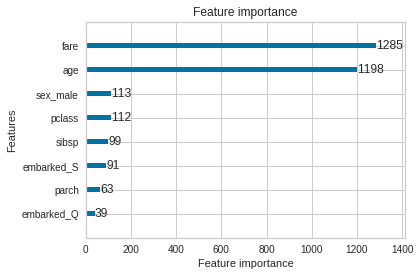

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
lgb.plot_importance(lgbm_class, ax=ax)
fig.tight_layout()

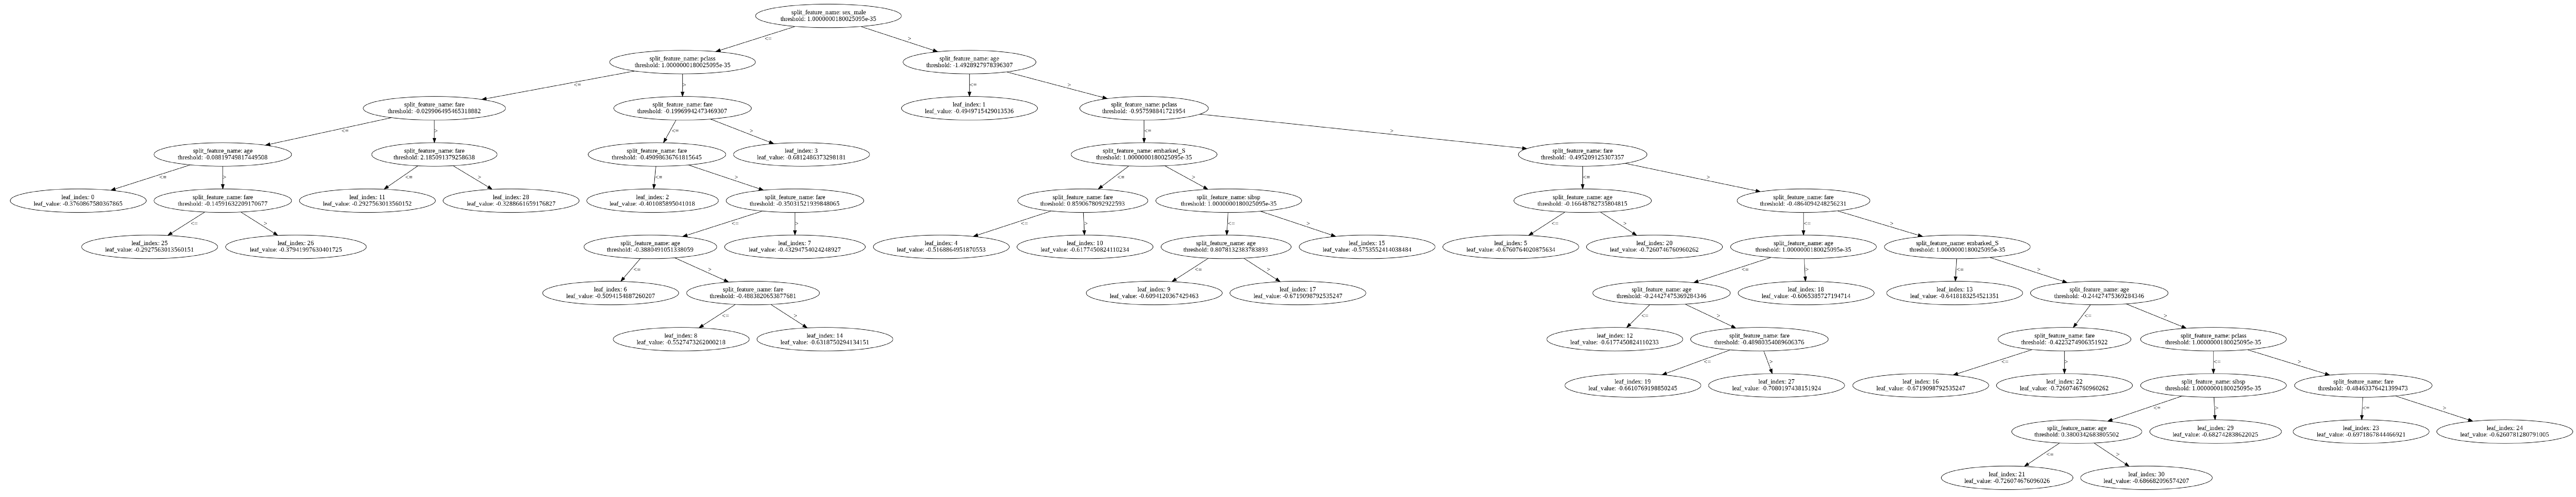

In [ ]:
fig, ax = plt.subplots(figsize=(200, 200))
lgb.plot_tree(lgbm_class, tree_index=0, ax=ax)

# 10.9 TPOT

In [ ]:
from tpot import TPOTClassifier
tc = TPOTClassifier(generations=2)
tc.fit(X_train, y_train)
tc.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Version 0.9.5 of tpot is outdated. Version 0.11.7 was released Wednesday January 06, 2021.


0.7888040712468194

In [ ]:
tc.predict(X.iloc[[0]])

array([0])

In [ ]:
tc.predict_proba(X.iloc[[0]])

array([[0.92383425, 0.07616575]])

In [ ]:
tc.export("tpot_exported_pipeline.py")

True

In [ ]:
!cat ./tpot_exported_pipeline.py

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# NOTE: Make sure that the class is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1).values
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'].values, random_state=None)

# Average CV score on the training set was:0.8209729151817534
exported_pipeline = RandomForestClassifier(bootstrap=False, criterion="entropy", max_features=0.5, min_samples_leaf=5, min_samples_split=18, n_estimators=100)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)
